In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from os import path, makedirs
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
from time import time
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import imageio

In [15]:
# ─── 환경 & 하이퍼파라미터 ────────────────────────────────────────────────
env       = gym.make('Pendulum-v1', render_mode='rgb_array')
env       = RecordVideo(
            env,
            video_folder="videos/",               # 저장 디렉터리 (없으면 생성됨)
            name_prefix="pendulum_eval"           # 파일명 접두사
)
dt        = env.unwrapped.dt
print(f'dt: {dt}')
exponent  = 0.5
gamma     = math.exp(- exponent * dt)
#sigma = 0.05
device    = "cuda:0" if torch.cuda.is_available() else "cpu"
print('Device: ', device)
device    = torch.device(device)

dt: 0.05
Device:  cuda:0


/home/namkyeong/anaconda3/envs/mujuco_simulation/lib/python3.9/site-packages/gymnasium/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /home/namkyeong/relaxed_control/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [16]:
# 결과 저장을 위한 디렉토리 생성
results_dir = "results/Pendulum"
makedirs(results_dir, exist_ok=True)

In [17]:
# 1) 문제 정의: drift, diffusion, cost, domain

def pendulum_dynamics_tensor(
    state: torch.Tensor, 
    torque: torch.Tensor, 
    env
) -> torch.Tensor: # For training
    """
    Vectorized Pendulum dynamics for torch tensors.

    Args:
        state: Tensor of shape [B, 2] containing [theta, theta_dot].
        torque: Tensor of shape [B] or [B, 1], the applied torque.
        env:   A Gymnasium Pendulum-v1 env (will be unwrapped).

    Returns:
        next_state: Tensor of shape [B, 3] containing
                    [cos(theta_new), sin(theta_new), theta_dot_new].
    """
    # grab raw env parameters
    env = env.unwrapped
    g          = env.g
    m          = env.m
    l          = env.l
    max_speed  = env.max_speed
    max_torque = env.max_torque
    dt         = env.dt

    # unpack state
    theta     = state[:, 0]
    theta_dot = state[:, 1]

    # clamp the torque
    torque = torch.clamp(torque.squeeze(-1) if torque.ndim > 1 else torque,
                         -max_torque, max_torque)

    # Euler integration of angular acceleration
    theta_dot_new = theta_dot + (
        (3 * g) / (2 * l) * torch.sin(theta)
        + (3.0 / (m * l**2)) * torque
    ) * dt
    theta_dot_new = torch.clamp(theta_dot_new, -max_speed, max_speed)

    # update angle
    theta_new = theta + theta_dot_new * dt

    # rebuild next_state as [cos, sin, theta_dot]
    next_state = torch.stack([
        theta_new,
        theta_dot_new
    ], dim=1)

    return next_state

def b(x, u):
    return (pendulum_dynamics_tensor(x,u,env) - x) / dt

def sigma(x, u):
    # x: [B, d], u: [B, m] -> diffusion sigma(x,u): [B, d, d]
    # u의 각 요소를 대각 성분으로 하는 대각 행렬을 생성합니다.
    S = 0.05 * torch.eye(d, device=device).unsqueeze(0).expand(x.shape[0], d, d)
    return S

def r(s, a):
    theta, theta_dot = s[:, 0], s[:, 1]
    return - ((theta**2) + 0.1 * (theta_dot**2) + 0.001 * (a**2).squeeze())



In [18]:
# 상태 및 제어 도메인 (박스 제약)
high = torch.tensor([torch.pi/2, 4.0], device=device)
X_domain = torch.stack([-high, high])
U_domain = torch.tensor([[-2.0], [2.0]], device=device)

def uniform_sample(n, domain):
    low = domain[0]
    high = domain[1]
    return low + (high - low) * torch.rand(n, low.shape[0], device=device)

In [19]:
# 2) 하이퍼파라미터
lam = 5      # 엔트로피 가중치
d = X_domain.shape[1]
m = U_domain.shape[1]
N_x = 100     # 상태(collocation) 샘플 수
N_u = 1000      # 정책 평가 시 행동 샘플 수
outer_iters = 12 # 전체 정책 반복 횟수
pi_improve_iters = 1000 # 정책 개선(improvement) 학습 반복 횟수
pi_improve_resample = 500 # batch 다시 뽑는 주기
v_eval_iters = 500     # 정책 평가(evaluation) 학습 반복 횟수
v_eval_resample = 200 # batch 다시 뽑는 주기

In [20]:
# 평가용 하이퍼파라미터
eval_num_traj = 30        # 평가 시뮬레이션 궤적 수
eval_traj_len = 200       # 각 궤적의 길이
eval_dt = 0.05            # 시뮬레이션 시간 스텝
rho = 10
gamma = math.exp(-rho * eval_dt) # 스텝마다의 할인율
print("gamma : " , gamma)

gamma :  0.6065306597126334


In [21]:

# 3) 뉴럴 네트워크 정의
# 3.1) 가치 네트워크 v_θ(x)
class ValueNet(nn.Module):
    def __init__(self, d, hidden=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden), nn.SiLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

# 3.2) 정책 네트워크 π_φ(u|x)
class PolicyNet(nn.Module):
    def __init__(self, d, m, hidden=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden), nn.SiLU(),
        )
        self.mean_head = nn.Linear(hidden, m)
        self.log_std_head = nn.Linear(hidden, m)
        self.log_std_min = -2.0
        self.log_std_max = 2.0

    def forward(self, x):
        features = self.net(x)
        mean = self.mean_head(features)
        log_std = self.log_std_head(features)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        std = torch.exp(log_std)
        return torch.distributions.Normal(mean, std)

    def sample(self, x, n_samples=1):
        with torch.no_grad():
            dist = self.forward(x)
            # dist.batch_shape = [B, m]
            # expand to [n_samples, B, m]
            dist_expanded = dist.expand((n_samples, *dist.batch_shape))
    
            # 1) 원시 샘플 u ~ N(mu, std)
            u = dist_expanded.sample()                # [n_samples, B, m]
    
            # 2) tanh + scaling → 실제 action space
            s = U_domain[1][0] / 2                    # scale
            tanh_u = torch.tanh(u)                    # [n_samples, B, m]
            a = s * tanh_u + s                        # [n_samples, B, m]
            ht_actions = a.transpose(0, 1)            # → [B, n_samples, m]
    
            # 3) 원시 u 에 대한 log prob
            log_p_u = dist_expanded.log_prob(u).sum(dim=-1)  # [n_samples, B]
    
            # 4) Jacobian 보정항: sum_i log(s * (1 - tanh(u_i)^2))
            #    = m * log(s) + sum_i log(1 - tanh(u_i)^2)
            log_det = (
                m * torch.log(s)
                + torch.log(1 - tanh_u.pow(2) + 1e-6).sum(dim=-1)
            )                                             # [n_samples, B]
    
            # 5) 변환된 action의 log prob
            log_probs = (log_p_u - log_det).transpose(0, 1)  # → [B, n_samples]
    
            return ht_actions, log_probs
            
    def rsample(self, x, n_samples=1):
        dist = self.forward(x)
        # dist.batch_shape = [B, m]
        # expand to [n_samples, B, m]
        dist_expanded = dist.expand((n_samples, *dist.batch_shape))

        # 1) 원시 샘플 u ~ N(mu, std)
        u = dist_expanded.sample()                # [n_samples, B, m]

        # 2) tanh + scaling → 실제 action space
        s = U_domain[1][0] / 2                    # scale
        tanh_u = torch.tanh(u)                    # [n_samples, B, m]
        a = s * tanh_u + s                        # [n_samples, B, m]
        ht_actions = a.transpose(0, 1)            # → [B, n_samples, m]

        # 3) 원시 u 에 대한 log prob
        log_p_u = dist_expanded.log_prob(u).sum(dim=-1)  # [n_samples, B]

        # 4) Jacobian 보정항: sum_i log(s * (1 - tanh(u_i)^2))
        #    = m * log(s) + sum_i log(1 - tanh(u_i)^2)
        log_det = (
            m * torch.log(s)
            + torch.log(1 - tanh_u.pow(2) + 1e-6).sum(dim=-1)
        )                                             # [n_samples, B]

        # 5) 변환된 action의 log prob
        log_probs = (log_p_u - log_det).transpose(0, 1)  # → [B, n_samples]

        return ht_actions, log_probs

In [22]:
# 4) 보조 함수

def grad(x, v_func):
    x = x.clone().requires_grad_(True)
    v_out = v_func(x)
    return torch.autograd.grad(v_out.sum(), x, create_graph=True)[0]

def grad_and_hess_diag(x, v_func):
    x = x.clone().requires_grad_(True)
    v_out = v_func(x)
    grad_v = torch.autograd.grad(v_out.sum(), x, create_graph=True)[0]
    hess_diag = []
    for i in range(x.shape[1]):
        g_i = grad_v[:, i].sum()
        h_ii = torch.autograd.grad(g_i, x, retain_graph=True)[0][:, i]
        hess_diag.append(h_ii)
    hess_diag = torch.stack(hess_diag, dim=1)
    return grad_v, hess_diag

def trace_sigma_d2v(x, u, v_func):
    S = sigma(x, u)
    Sigma = S @ S.transpose(-1, -2)
    _, hess_diag = grad_and_hess_diag(x, v_func)
    Sigma_diag = Sigma.diagonal(dim1=-2, dim2=-1)
    return (Sigma_diag * hess_diag).sum(dim=-1) # [B]

In [23]:
# 5) 평가 함수
def evaluate_policy(policy_net, num_traj, traj_len, dt):
    print('Start evaluating')
    policy_net.eval() # 평가 모드
    total_rewards = []
    

    # 초기 상태는 0 벡터로 시작
    x = torch.zeros(num_traj, d, device=device)
    episode_reward = torch.zeros(num_traj, device=device)
    x_norm_hist = torch.zeros(num_traj, traj_len, device = device)
    
    for _ in range(traj_len):
        # sample from policy
        #print(f'state shape: {x.shape}')
        u = policy_net.sample(x)[0].squeeze(1) # [num_traj, m]
        #print(u.shape)
        
        # 보상 계산
        current_reward = r(x, u) # [B]
        episode_reward += current_reward * (gamma ** _) # [B]
        
        # 다음 상태 계산 (Euler-Maruyama)
        drift_term = b(x, u) # [num_traj, d]
        diffusion_term = (sigma(x, u) @ torch.randn(num_traj, d, 1, device=device)).squeeze(2)
        #print(f'diffusion term shape: {diffusion_term.shape}')

        #print(x.shape, drift_term.shape, diffusion_term.shape)
        x = x + drift_term * dt + diffusion_term * np.sqrt(dt)
        #x = torch.clamp(x, X_domain[0][0], X_domain[1][0])
        x_norm_hist[:,_] = torch.norm(x, dim=1)

    x_norm_hist = torch.mean(x_norm_hist, dim=0) 
    policy_net.train() # 다시 학습 모드로
    return torch.mean(episode_reward), x_norm_hist

In [24]:
def project_onto_l2_ball(s, radius=0.1):
    norm = np.linalg.norm(s)
    if norm <= radius:
        return s
    else:
        return s * (radius / norm)

In [25]:
# 네트워크 및 옵티마이저 초기화
v_net = ValueNet(d).to(device)
pi_net = PolicyNet(d, m).to(device)
v_optimizer = optim.Adam(v_net.parameters(), lr=1e-3)
pi_optimizer = optim.Adam(pi_net.parameters(), lr=1e-4)

In [26]:
# 6) 정책 반복(Policy Iteration) 루프
reward_history = []
x_norm_hist_hist = torch.zeros(outer_iters, eval_traj_len, device=device)
start = time()
for outer in range(outer_iters):
    print(f'------------ Iteration: {outer+1}/{outer_iters} --------------')
    
    # 6.1) 정책 개선 (Policy Improvement)
    print("--> Policy Improvement...")
    pi_net.train()
    for it in range(pi_improve_iters):
        pi_optimizer.zero_grad()
        
        # resample batch
        if it % pi_improve_resample == 0:
            x_coll = uniform_sample(N_x, X_domain)
            #print('x_coll', x_coll.shape)
            x_flat = x_coll.unsqueeze(1).expand(-1, N_u, -1) # [N_x, N_u, d]
            #print('x_flat', x_flat.shape)
            x_flat = x_flat.reshape(-1, d)
            #print('x_flat', x_flat.shape)
        
        u_flat, log_pi = pi_net.rsample(x_coll, n_samples=N_u) # [N_x, N_u, m], [N_x, N_u]
        u_flat = u_flat.reshape(-1, m)
        #print('u_flat', u_flat.shape)

        grad_v = grad(x_flat, v_net).detach() # grad_v shape = [N_x * N_u, d] 
        #print('grad_v', grad_v.shape)
        #trace_term = trace_sigma_d2v(x_coll, u_samples, v_net # [N_x]
        with torch.no_grad():
        #print('b', b(x_flat, u_flat).shape)
        #print('r', r(x_flat, u_flat).shape)
            h_inst = (b(x_flat, u_flat) * grad_v).sum(dim=1) + r(x_flat, u_flat)
        #print('h_inst', h_inst.shape)
            h_inst = h_inst.reshape(N_x, N_u)
            # h_inst shape = [N_x, N_u]
            # h_inst를 계산한 후 그래프에서 분리하여 v_net으로 그래디언트가 흐르지 않도록 합니다.

        pi_loss = (lam * log_pi - h_inst).mean() # mean or sum?
        pi_loss.backward()
        pi_optimizer.step()
        if (it + 1) % 100 == 0:
            print(f"Policy Improvement Loss {it + 1}: {pi_loss.item():.4e} Time: {time() - start:.2f}s")

    # 6.2) 정책 평가 (Policy Evaluation)
    print("--> Policy Evaluation...")
    v_net.train()
    v_net_old_state = {k: v.clone() for k, v in v_net.state_dict().items()}
    for it in range(v_eval_iters):
        # resample batch 
        if it % v_eval_resample == 0:
            x_flat = uniform_sample(N_x, X_domain)
            with torch.no_grad():
                u_flat, log_pi = pi_net.sample(x_flat, n_samples=N_u) # [N_x, N_u, m]
            x_flat = x_flat.unsqueeze(1).expand(-1, N_u, -1) # [N_x, N_u, d]
            x_flat, u_flat = x_flat.reshape(-1, d), u_flat.reshape(-1, m)

        #print(f'Policy Evaluation Iter: {it + 1}')
        v_optimizer.zero_grad()
        #print(f'min log_pi: {log_pi.min().item()}')
        #print(f'max log_pi: {log_pi.max().item()}')
        #print(f'v_net(x_coll) has nan: {torch.isnan(v_net(x_coll)).any()}')
        #grad_v = grad(x_flat, v_net) # grad_v shape = [N_x * N_u, d]
        #print(f'grad_v has nan: {torch.isnan(grad_v).any()}')
        #trace_term = trace_sigma_d2v(x_flat, u_flat, v_net) # [N_x * N_u]
        #print(f'trace_term has nan: {torch.isnan(trace_term).any()}')
        #print('b', b(x_flat, u_flat).shape)
        #print('grad_v', grad(x_flat, v_net).shape)
        #print('trace', trace_sigma_d2v(x_flat, u_flat, v_net).shape)
        #print('r', r(x_flat, u_flat).shape)
        h_inst = (b(x_flat, u_flat) * grad(x_flat, v_net)
                     ).sum(dim=1)  + 0.5 * trace_sigma_d2v(x_flat, u_flat, v_net) + r(x_flat, u_flat)
        h_inst = h_inst.view(N_x, N_u) # [N_x, N_u]
        #print(f'h_inst has nan: {torch.isnan(h_inst).any()}')
        h_inst -= lam * log_pi
        h_inst = h_inst.mean(dim=1) # [N_x]
        #print(f'E_term has nan: {torch.isnan(E_term).any()}')
        x_coll = x_flat.reshape(N_x, N_u, d)[:,0,:]
        v_x = v_net(x_coll) # [N_x]
        #print(f'v_x has nan: {torch.isnan(v_x).any()}')
        #R = rho * v_x - h_inst # [N_x]
        #print(f'R has nan: {torch.isnan(R).any()}')
        v_loss = ((rho * v_x - h_inst) ** 2).mean()
        #print(f'v_loss has nan: {torch.isnan(v_loss).any
        v_loss.backward()
        v_optimizer.step()
        if (it + 1) % 100 == 0:
            print(f"Policy Evaluation Loss {it + 1}: {v_loss.item():.4e} Time: {time() - start:.2f}s")

    # 6.3) 현재 정책 성능 평가 및 기록
    avg_reward, x_norm_hist = evaluate_policy(pi_net, eval_num_traj, eval_traj_len, eval_dt)
    avg_reward = avg_reward.item()
    reward_history.append(avg_reward)
    x_norm_hist_hist[outer, :] = x_norm_hist
    print(f"Evaluation Average Reward: {avg_reward:.4e} Time: {time() - start:.2f}s")

#     eval_traj_num = 10
#     for ep in range(eval_traj_num):
#         #print(f'eval traj {ep+1}')
#         # env.reset() 가 (obs, info) 튜플일 수 있으므로 unpack
#         init = env.reset()
#         env.unwrapped.state = project_onto_l2_ball(env.unwrapped.state, 0.3)
#         #s = init[0] if isinstance(init, tuple) else init
        
    
#         total = 0
#         done = False
#         step = 0
        
#         #all_frames = []
#         while not done:
#             #frame = env.render()
#             #all_frames.append(frame)
#             step += 1
#             #print(f'step: {step}')
#             s_ = env.unwrapped.state
#             a = np.array([greedy_action(value_net, s_, env)])
#             #print(f'a shape: {a.shape}')
#             s2, r, terminated, truncated, _ = env.step(a)
#             s2 = env.unwrapped.state
            
#             # ─── Gaussian noise 주입 ────────────────────────────
#             tau = env.unwrapped.dt
#             # 평균 0, 분산 = sigma^2 * tau 인 정규분포
#             noise = np.random.normal(
#                 loc=0.0,
#                 scale=sigma * np.sqrt(tau),
#                 size=s2.shape
#             )
#             s = angle_normalize(s2 + noise)
#             # 실제 env.state 를 덮어쓰기
#             env.unwrapped.state = s
            
#             done = terminated or truncated or (step >= 500)
    
#             total += r * (gamma ** step)

#         eval_reward += total
#         eval_step += step
#     eval_reward /= eval_traj_num
#     eval_step /= eval_traj_num
#     print(f'Estimated Value: {eval_reward} Estimated Step: {eval_step} Runtime: {time.time() - start}')
#     total_reward.append(eval_reward)
    # 6.4) 수렴 확인 (선택 사항)
    with torch.no_grad():
        v_old = ValueNet(d).to(device)
        v_old.load_state_dict(v_net_old_state)
        v_new_values = v_net(x_coll)
        v_old_values = v_old(x_coll)
        delta = torch.norm(v_new_values - v_old_values, p=2) / torch.sqrt(torch.tensor(N_x, device=device))
        print(f"Δv = {delta:.4e}")
        if delta < 1e-3:
            print("✔️ Policy-iteration converged.")
            break


    if outer == outer_iters - 1:
        print(f"✔️ Policy-iteration finished. Total Runtime: {time() - start:.2f}s")

------------ Iteration: 1/10000 --------------
--> Policy Improvement...
Policy Improvement Loss 100: -2.1200e+00 Time: 0.25s
Policy Improvement Loss 200: -2.0928e+00 Time: 0.50s
Policy Improvement Loss 300: -2.0480e+00 Time: 0.74s
Policy Improvement Loss 400: -2.0146e+00 Time: 0.99s
Policy Improvement Loss 500: -1.7313e+00 Time: 1.23s
Policy Improvement Loss 600: -1.6797e+00 Time: 1.48s
Policy Improvement Loss 700: -1.7796e+00 Time: 1.73s
Policy Improvement Loss 800: -1.9094e+00 Time: 1.97s
Policy Improvement Loss 900: -1.9675e+00 Time: 2.21s
Policy Improvement Loss 1000: -1.8961e+00 Time: 2.46s
--> Policy Evaluation...
Policy Evaluation Loss 100: 3.6934e-02 Time: 3.67s
Policy Evaluation Loss 200: 2.7478e-02 Time: 4.89s
Policy Evaluation Loss 300: 2.5896e-02 Time: 6.11s
Policy Evaluation Loss 400: 2.2968e-02 Time: 7.32s
Policy Evaluation Loss 500: 2.3682e-02 Time: 8.54s
Start evaluating
Evaluation Average Reward: -1.1670e-01 Time: 8.64s
Δv = 1.9707e-01
------------ Iteration: 2/10000 

Policy Improvement Loss 700: -7.0083e-01 Time: 70.80s
Policy Improvement Loss 800: -6.7499e-01 Time: 71.05s
Policy Improvement Loss 900: -6.5187e-01 Time: 71.30s
Policy Improvement Loss 1000: -6.5442e-01 Time: 71.54s
--> Policy Evaluation...
Policy Evaluation Loss 100: 4.1174e-03 Time: 72.76s
Policy Evaluation Loss 200: 4.0441e-03 Time: 73.98s
Policy Evaluation Loss 300: 5.4677e-03 Time: 75.19s
Policy Evaluation Loss 400: 5.3130e-03 Time: 76.41s
Policy Evaluation Loss 500: 3.6502e-03 Time: 77.63s
Start evaluating
Evaluation Average Reward: -1.2031e-01 Time: 77.74s
Δv = 5.4007e-02
------------ Iteration: 10/10000 --------------
--> Policy Improvement...
Policy Improvement Loss 100: -9.9351e-01 Time: 77.99s
Policy Improvement Loss 200: -9.6392e-01 Time: 78.23s
Policy Improvement Loss 300: -1.0824e+00 Time: 78.48s
Policy Improvement Loss 400: -1.0338e+00 Time: 78.72s
Policy Improvement Loss 500: -1.0810e+00 Time: 78.97s
Policy Improvement Loss 600: -8.4410e-01 Time: 79.21s
Policy Improvem

Policy Evaluation Loss 300: 9.1624e-03 Time: 144.45s
Policy Evaluation Loss 400: 8.5337e-03 Time: 145.67s
Policy Evaluation Loss 500: 9.9085e-03 Time: 146.89s
Start evaluating
Evaluation Average Reward: -1.3497e-01 Time: 147.00s
Δv = 2.6838e-01
------------ Iteration: 18/10000 --------------
--> Policy Improvement...
Policy Improvement Loss 100: 1.7379e+00 Time: 147.25s
Policy Improvement Loss 200: 1.6879e+00 Time: 147.49s
Policy Improvement Loss 300: 1.6605e+00 Time: 147.74s
Policy Improvement Loss 400: 1.7429e+00 Time: 147.99s
Policy Improvement Loss 500: 1.6781e+00 Time: 148.23s
Policy Improvement Loss 600: 1.5578e+00 Time: 148.48s
Policy Improvement Loss 700: 1.3547e+00 Time: 148.72s
Policy Improvement Loss 800: 1.3140e+00 Time: 148.97s
Policy Improvement Loss 900: 1.1637e+00 Time: 149.21s
Policy Improvement Loss 1000: 1.1972e+00 Time: 149.46s
--> Policy Evaluation...
Policy Evaluation Loss 100: 1.2246e-02 Time: 150.68s
Policy Evaluation Loss 200: 9.7269e-03 Time: 151.90s
Policy Ev

KeyboardInterrupt: 

In [35]:
# 보상 기록 저장
reward_file = path.join(results_dir, "reward_history.npy")
np.save(reward_file, np.array(reward_history))
print(f"Reward history saved to {reward_file}")

Reward history saved to results/Pendulum/reward_history.npy


In [36]:
reward_file = path.join(results_dir, "reward_history.npy")
reward_history = np.load(reward_file)
print("Loaded reward history")

Loaded reward history


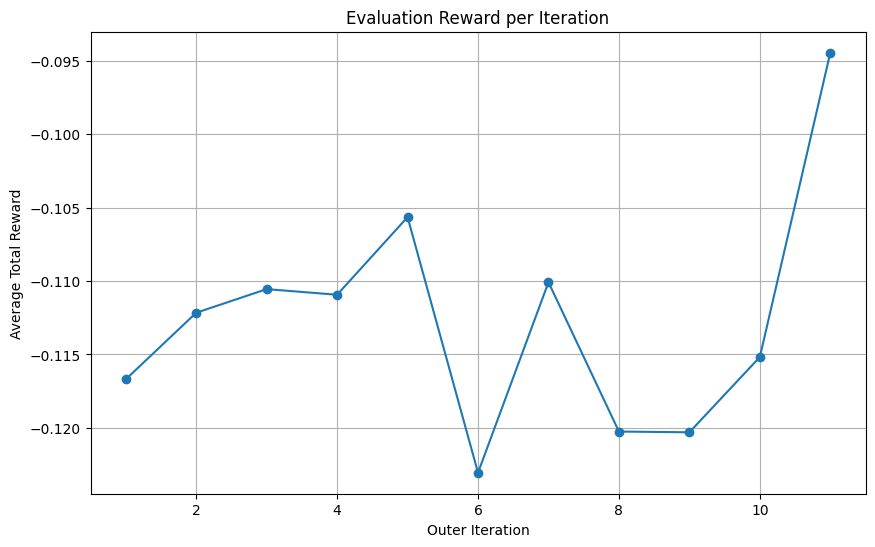

Reward plot saved to results/Pendulum/reward_plot.png


<Figure size 640x480 with 0 Axes>

In [32]:
# 보상 그래프 시각화 및 저장
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11 + 1), reward_history[:11], marker='o')
plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
plt.show()
plot_file = path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

In [33]:


# 모델 체크포인트 저장
v_net_file = path.join(results_dir, "v_net.pth")
pi_net_file = path.join(results_dir, "pi_net.pth")
torch.save(v_net.state_dict(), v_net_file)
torch.save(pi_net.state_dict(), pi_net_file)
print(f"Value network saved to {v_net_file}")
print(f"Policy network saved to {pi_net_file}")





Value network saved to results/Pendulum/v_net.pth
Policy network saved to results/Pendulum/pi_net.pth


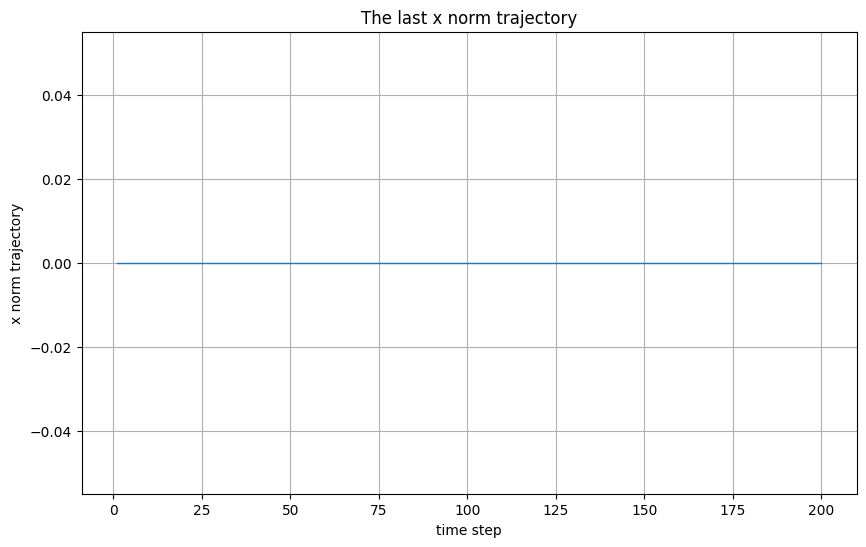

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, eval_traj_len + 1), x_norm_hist_hist[-1].cpu().numpy(), linewidth=1.0)
plt.title("The last x norm trajectory")
plt.xlabel("time step")
plt.ylabel("x norm trajectory")
plt.grid(True)
plot_file = path.join(results_dir, "last_x_norm_trajectory.png")
plt.savefig(plot_file)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, outer_iters + 1), x_norm_hist_hist[:, -1].cpu().numpy(), linewidth=1.0)
plt.title("Final x norm")
plt.xlabel("Outer Iteration")
plt.ylabel("Final x norm")
plt.grid(True)
plot_file = path.join(results_dir, "Final_x_norm.png")
plt.savefig(plot_file)
plt.show()